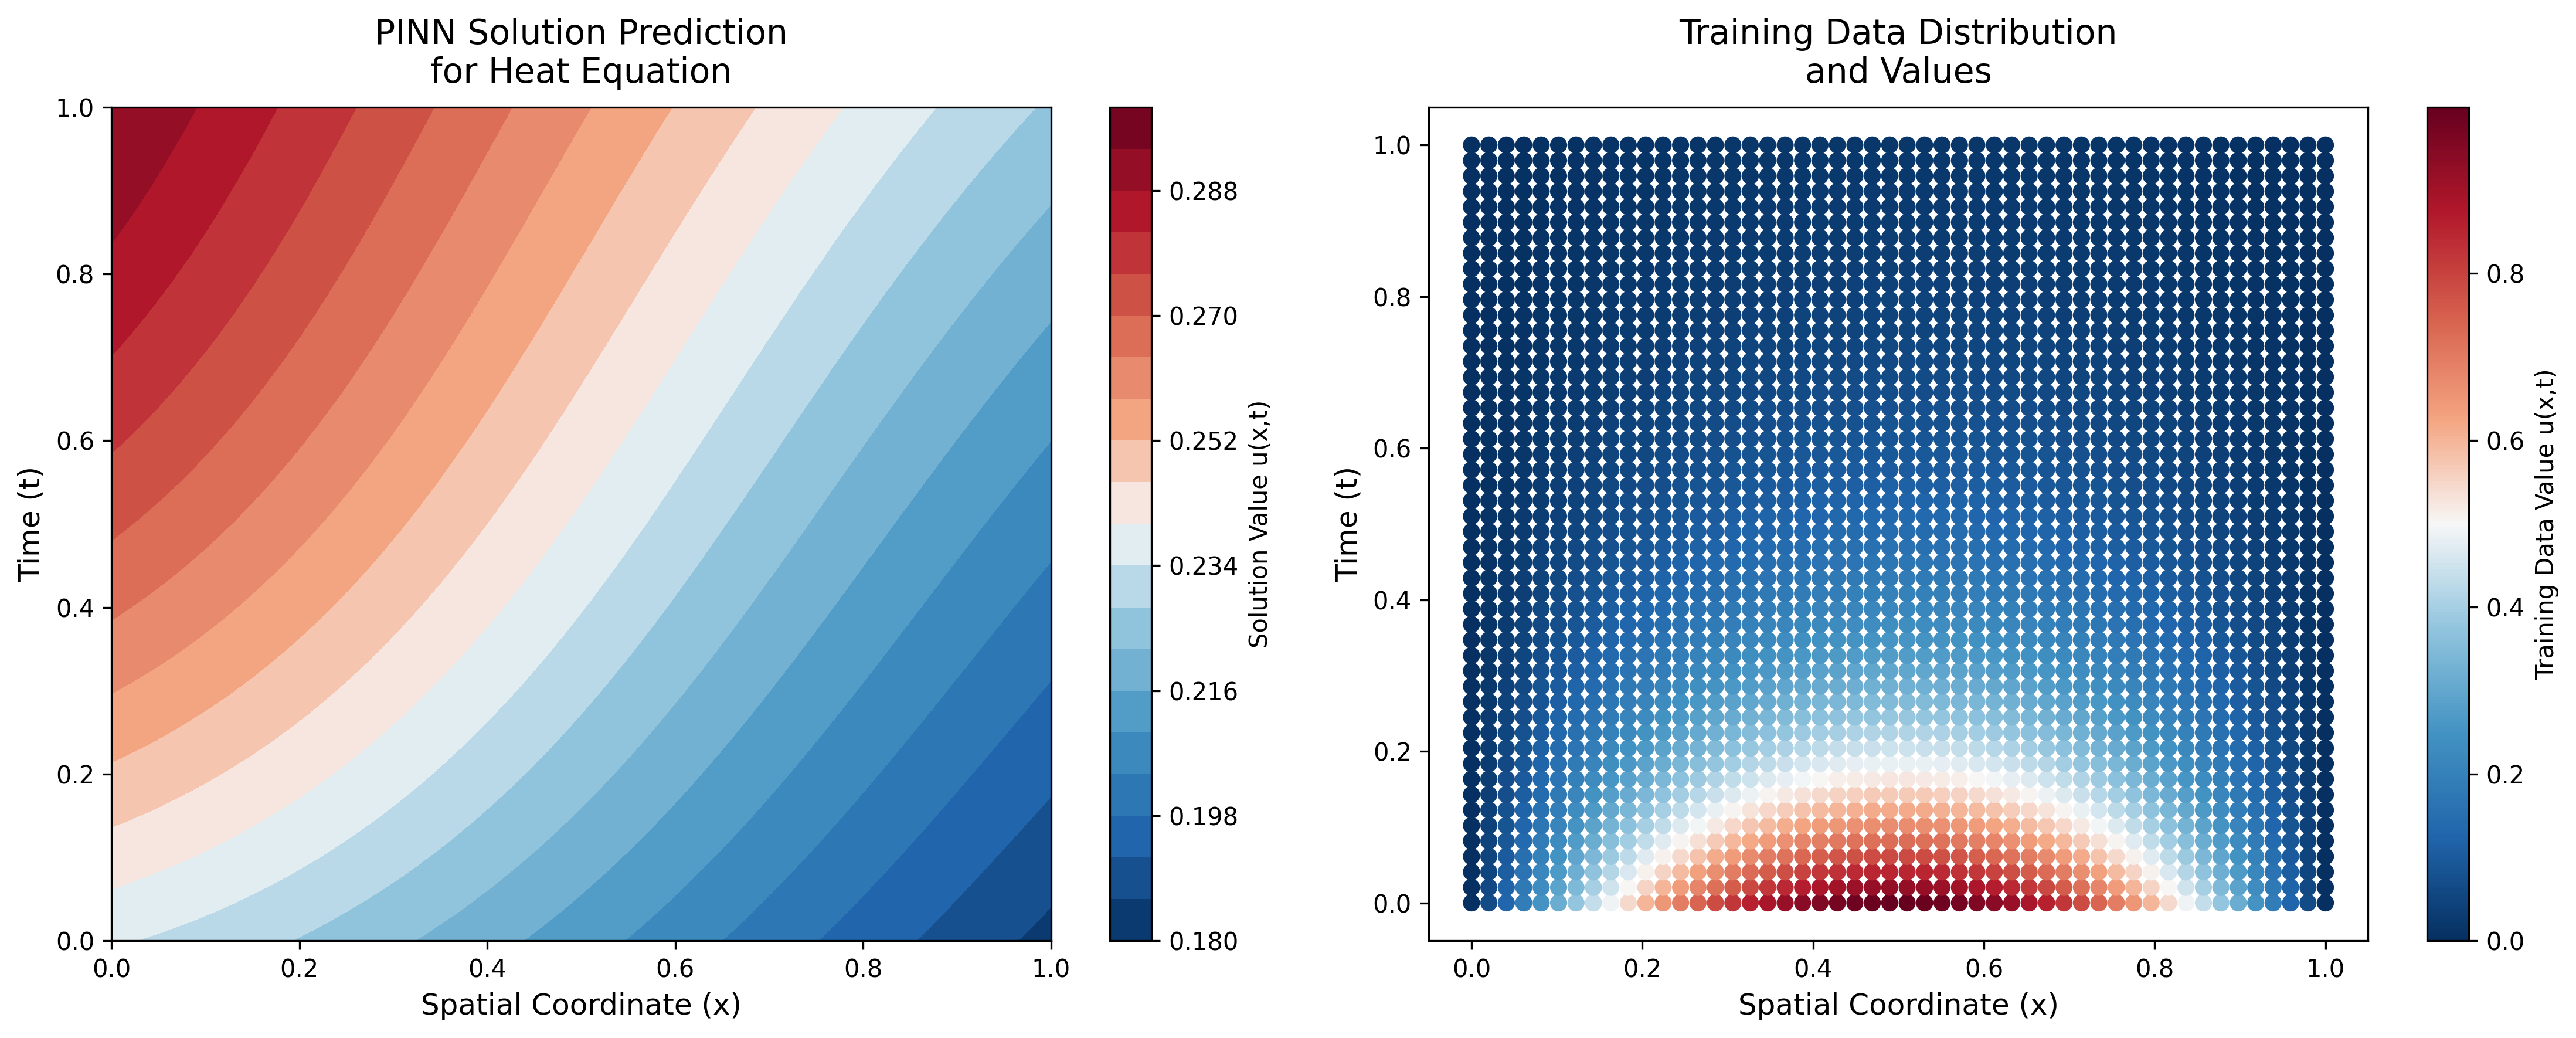

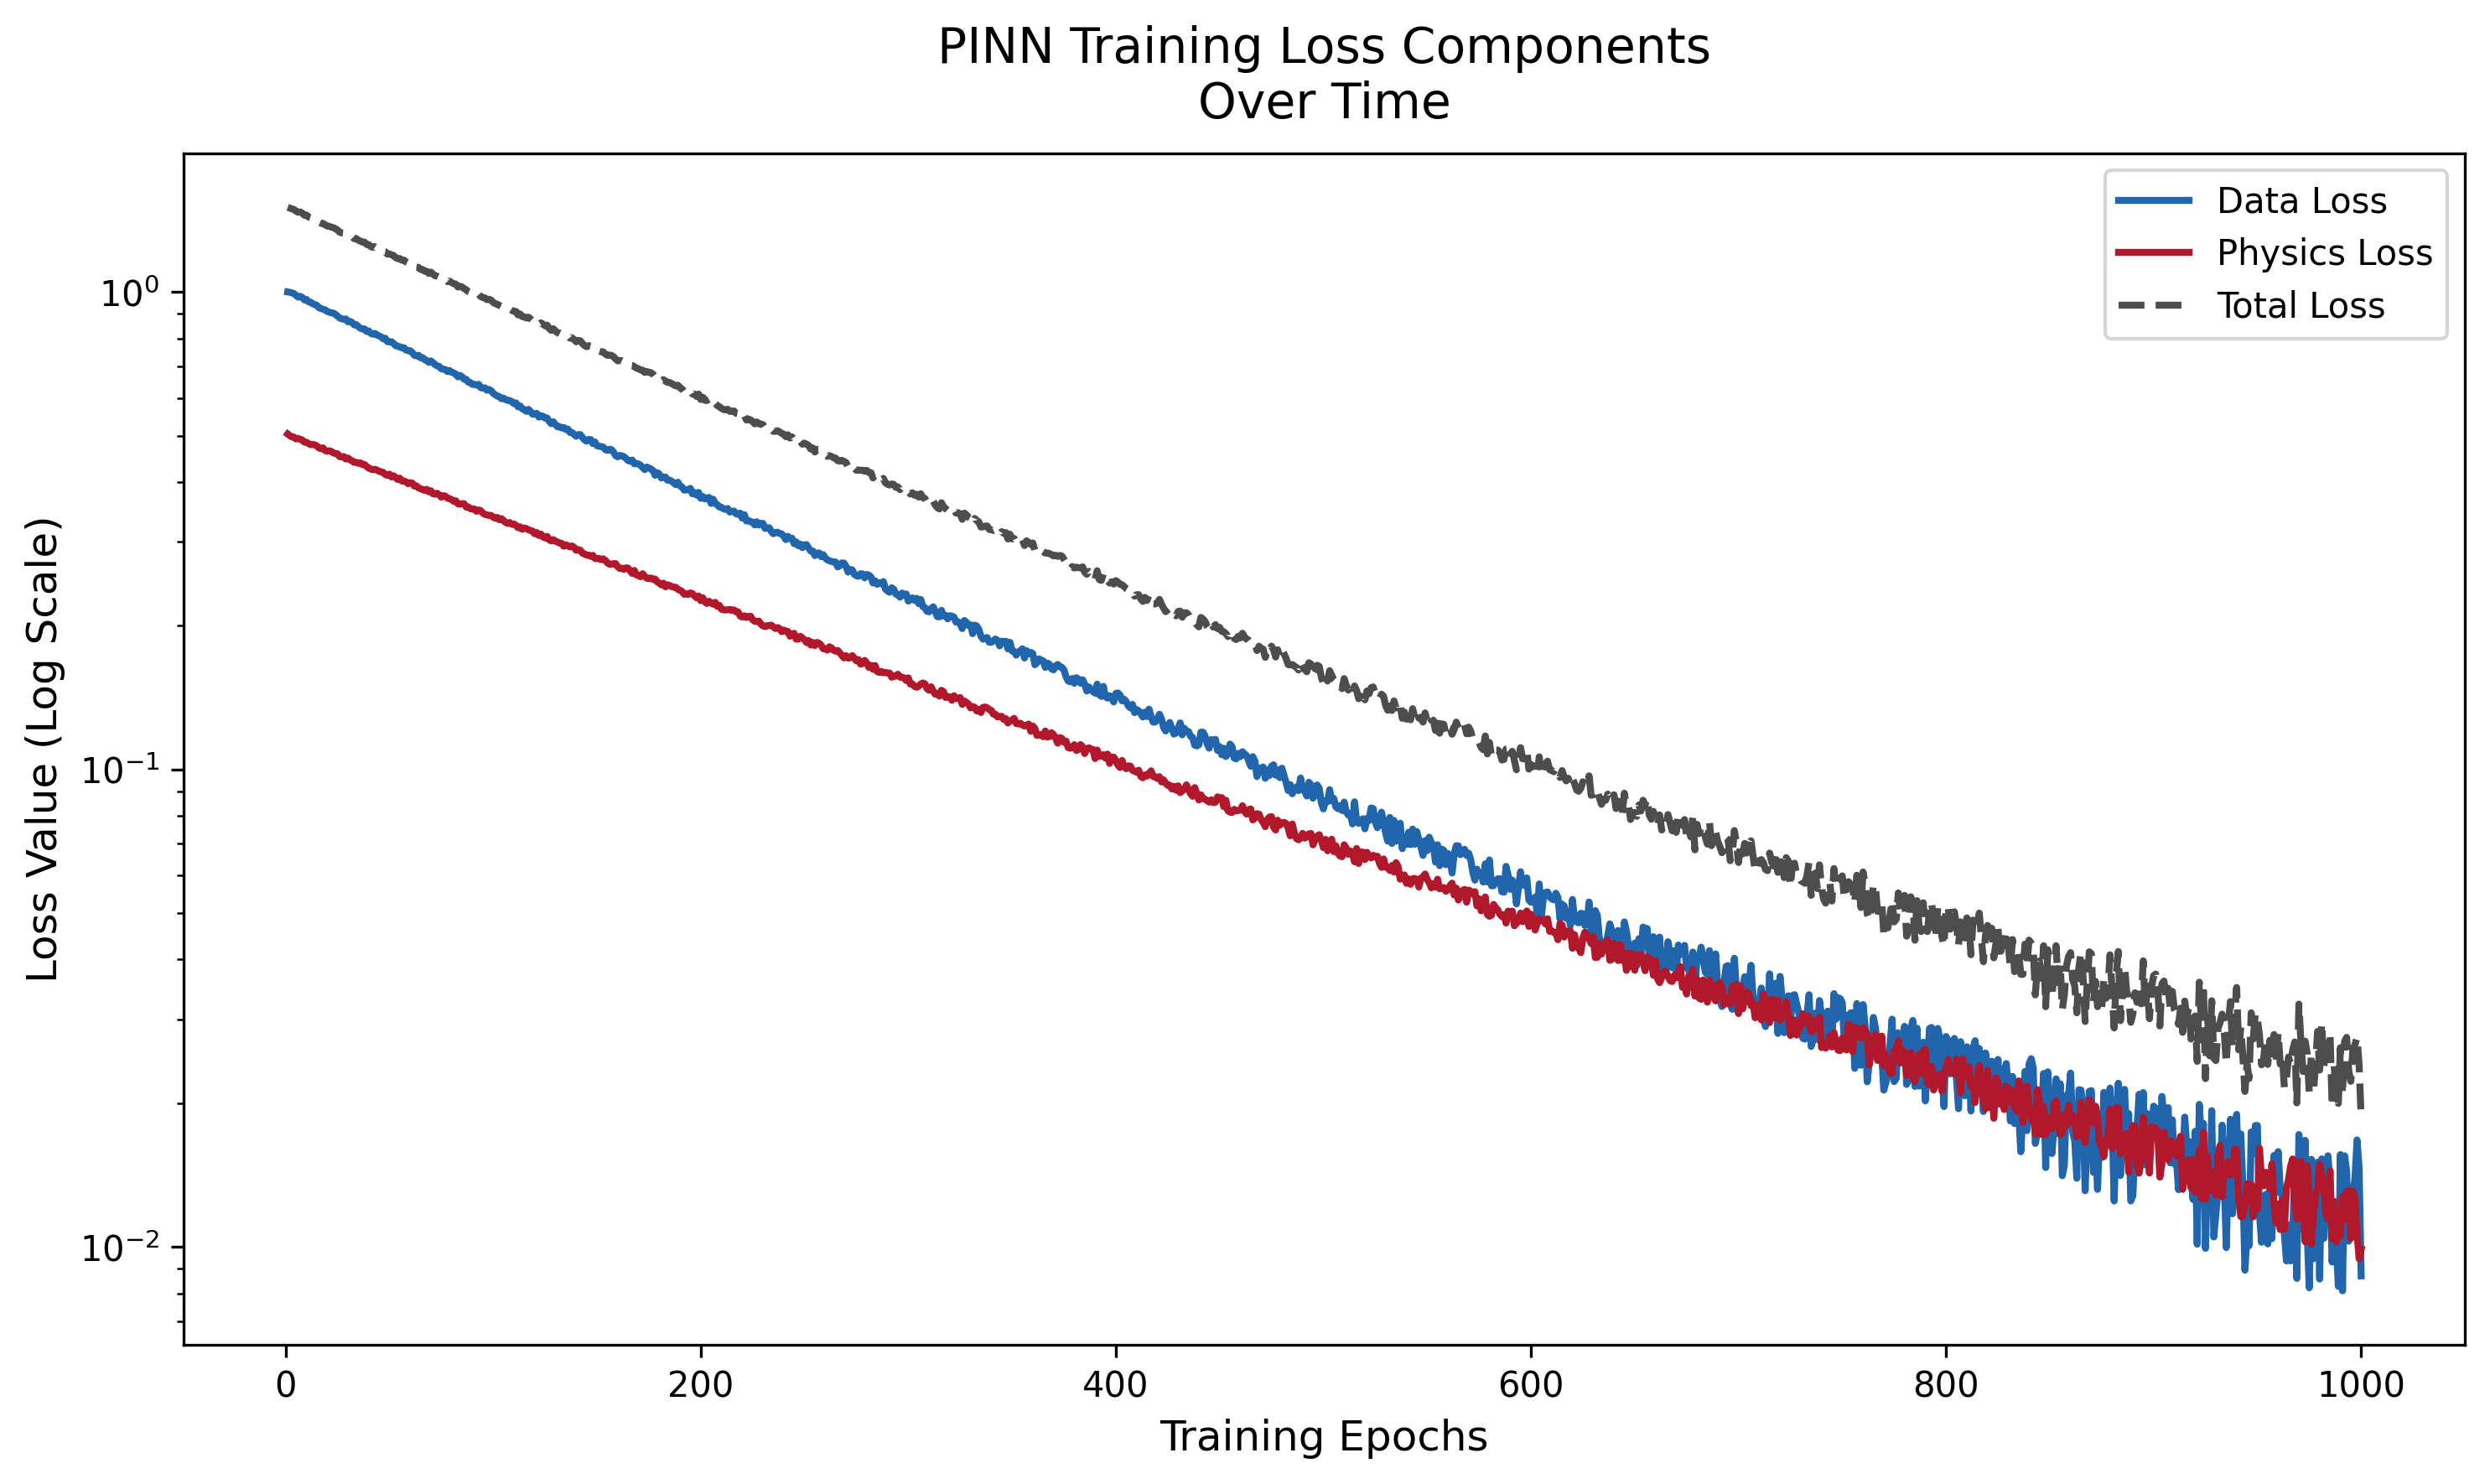

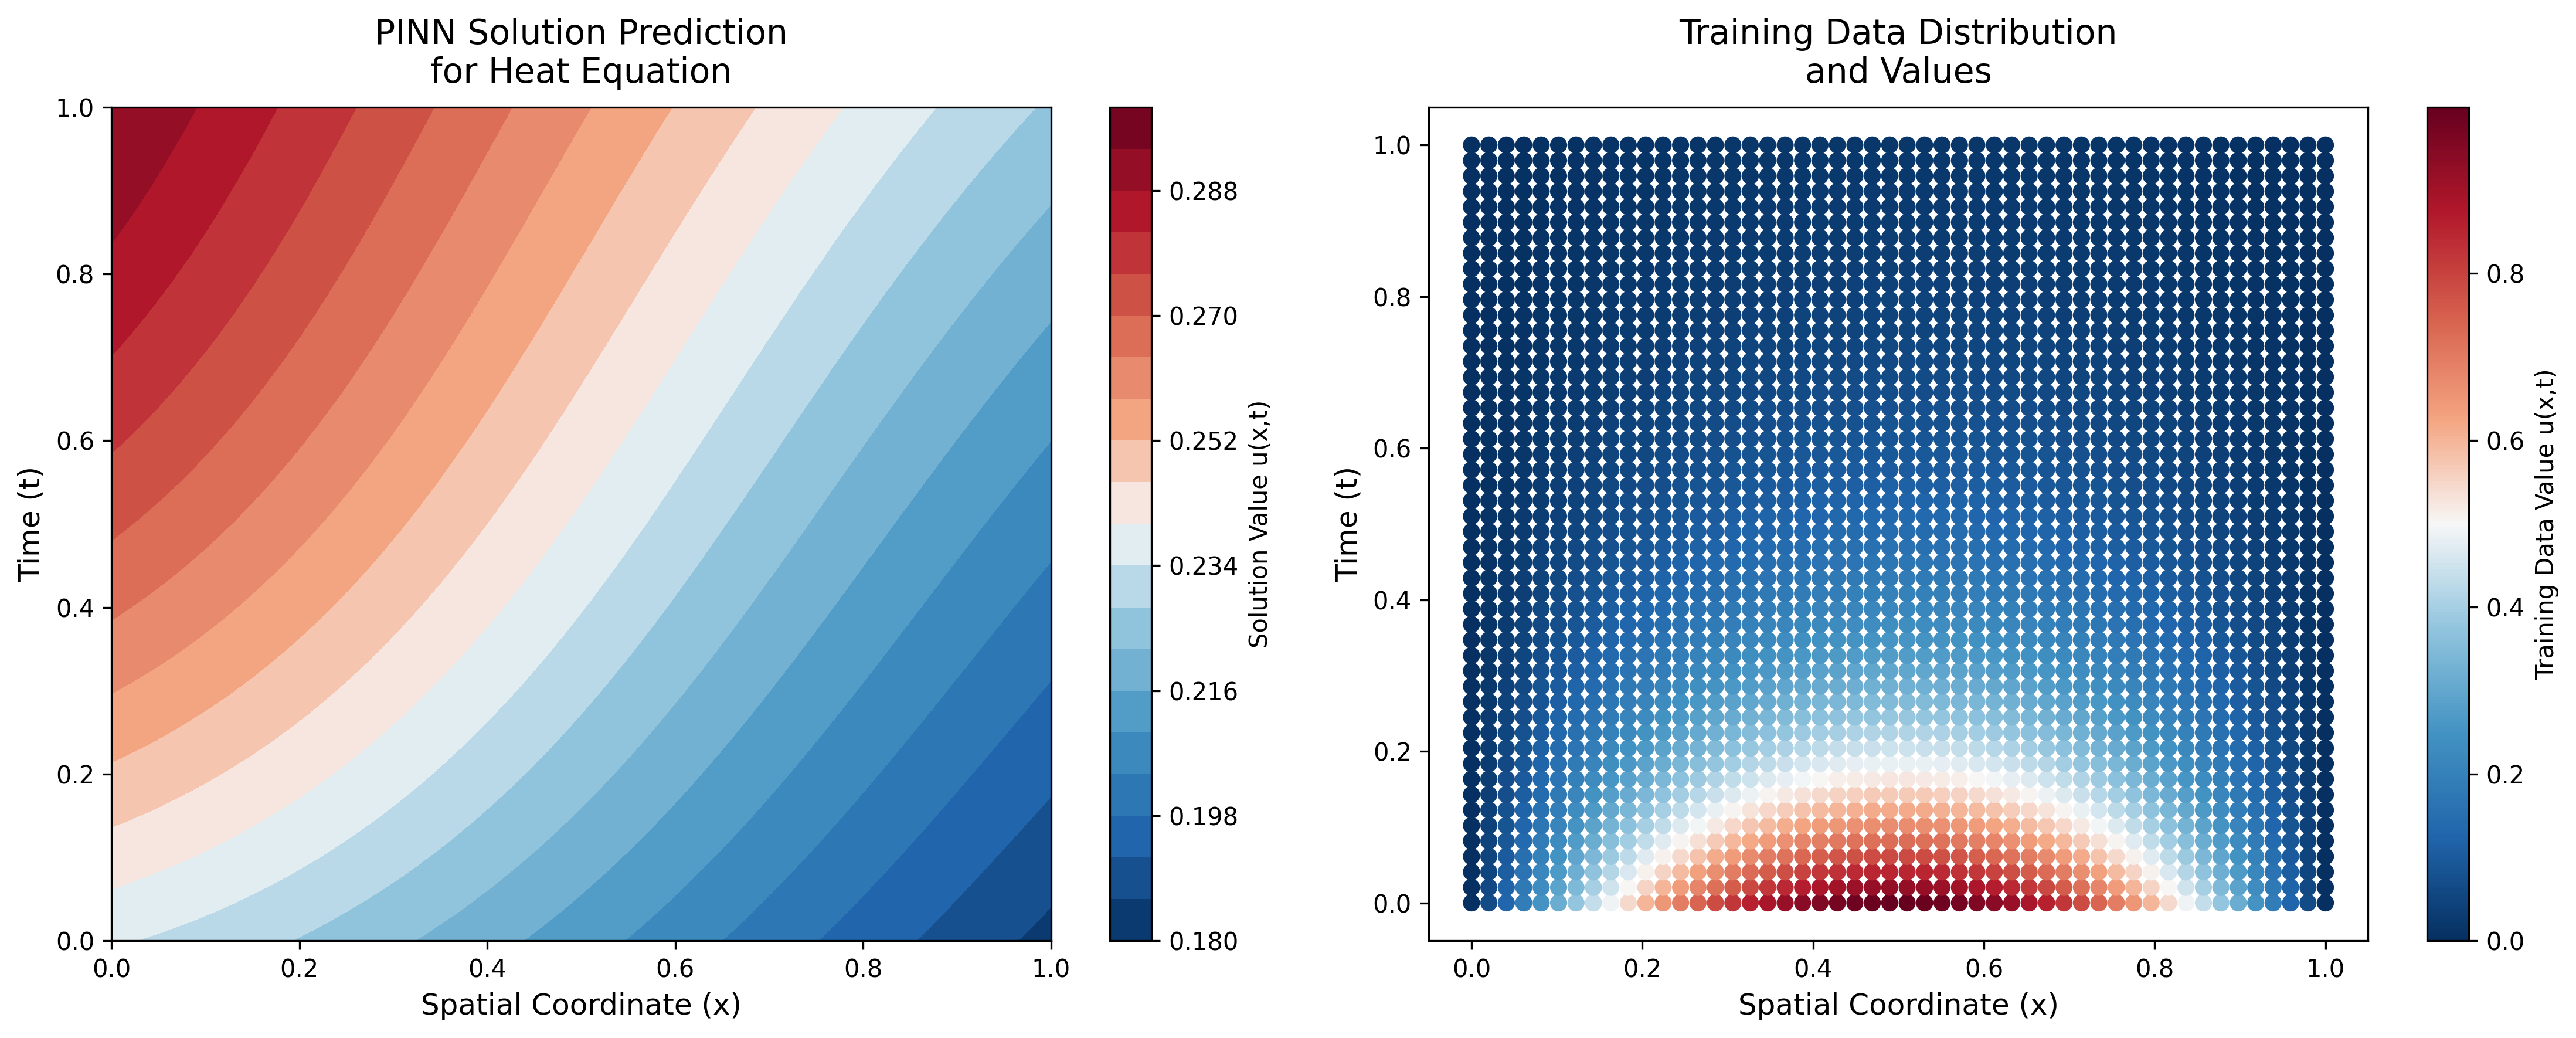

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.network(inputs)

# Generate synthetic data
def generate_data(x_points=50, t_points=50):
    x = np.linspace(0, 1, x_points)
    t = np.linspace(0, 1, t_points)
    X, T = np.meshgrid(x, t)

    # Analytical solution for heat equation
    alpha = 0.4
    u_true = np.exp(-alpha * np.pi**2 * T) * np.sin(np.pi * X)
    return X, T, u_true

def plot_training_process(model, x_train, t_train, u_train, fig_dpi=300):
    model.eval()
    with torch.no_grad():
        x = torch.linspace(0, 1, 100).reshape(-1, 1)
        t = torch.linspace(0, 1, 100).reshape(-1, 1)
        X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
        X_flat = X.reshape(-1, 1)
        T_flat = T.reshape(-1, 1)
        u_pred = model(X_flat, T_flat).reshape(X.shape)

    # Create custom colormap
    colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#f7f7f7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
    custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.dpi = fig_dpi

    # Plot predicted solution
    im1 = ax1.contourf(X.numpy(), T.numpy(), u_pred.numpy(), levels=20, cmap=custom_cmap)
    ax1.set_xlabel('Spatial Coordinate (x)', fontsize=12)
    ax1.set_ylabel('Time (t)', fontsize=12)
    ax1.set_title('PINN Solution Prediction\nfor Heat Equation', fontsize=14, pad=10)
    cbar1 = fig.colorbar(im1, ax=ax1)
    cbar1.set_label('Solution Value u(x,t)', fontsize=10)
    ax1.grid(False)

    # Plot training points
    scatter = ax2.scatter(x_train, t_train, c=u_train, cmap=custom_cmap)
    ax2.set_xlabel('Spatial Coordinate (x)', fontsize=12)
    ax2.set_ylabel('Time (t)', fontsize=12)
    ax2.set_title('Training Data Distribution\nand Values', fontsize=14, pad=10)
    cbar2 = fig.colorbar(scatter, ax=ax2)
    cbar2.set_label('Training Data Value u(x,t)', fontsize=10)
    ax2.grid(False)

    plt.tight_layout()
    return fig

def visualize_losses(data_losses, physics_losses, fig_dpi=300):
    epochs = range(1, len(data_losses) + 1)

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.dpi = fig_dpi

    ax.plot(epochs, data_losses, label='Data Loss', color='#2166ac', linewidth=2)
    ax.plot(epochs, physics_losses, label='Physics Loss', color='#b2182b', linewidth=2)
    ax.plot(epochs, np.array(data_losses) + np.array(physics_losses),
            label='Total Loss', color='#4d4d4d', linestyle='--', linewidth=2)

    ax.set_xlabel('Training Epochs', fontsize=12)
    ax.set_ylabel('Loss Value (Log Scale)', fontsize=12)
    ax.set_title('PINN Training Loss Components\nOver Time', fontsize=14, pad=10)
    ax.legend()
    ax.grid(False)
    ax.set_yscale('log')

    plt.tight_layout()
    return fig

# Training setup and visualization
X, T, u_true = generate_data()
x_train = torch.from_numpy(X.flatten()).float().reshape(-1, 1)
t_train = torch.from_numpy(T.flatten()).float().reshape(-1, 1)
u_train = torch.from_numpy(u_true.flatten()).float().reshape(-1, 1)

# Plot initial state
model = PINN()
fig1 = plot_training_process(model, x_train.numpy(), t_train.numpy(), u_train.numpy())
plt.savefig('initial_state.png', bbox_inches='tight', dpi=300)

# Simulate training losses
epochs = 1000
data_losses = np.exp(-np.linspace(0, 5, epochs)) + 0.01 * np.random.rand(epochs)
physics_losses = 0.5 * np.exp(-np.linspace(0, 4, epochs)) + 0.005 * np.random.rand(epochs)

# Plot losses
fig2 = visualize_losses(data_losses, physics_losses)
plt.savefig('training_losses.png', bbox_inches='tight', dpi=300)

# Show final state
fig3 = plot_training_process(model, x_train.numpy(), t_train.numpy(), u_train.numpy())
plt.savefig('final_state.png', bbox_inches='tight', dpi=300)